# Подключаем необходимые библиотеки

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from pandas import datetime
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

In [148]:
warnings.simplefilter('ignore')

# Считываем наши данные

In [149]:
data = pd.read_csv('products.csv', sep='|', error_bad_lines=False)

# Рассмотрим отдельный поднабор категории dry_eye

In [150]:
dry_eye = data[data['PRODUCT_CATEGORY_LABEL']=='DRY EYE']

# Рассмотрим его подробнее

In [151]:
dry_eye.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48186 entries, 1673 to 19461110
Data columns (total 11 columns):
WEEK                      48186 non-null object
PLN                       48186 non-null object
PLN_LABEL                 48186 non-null object
PRODUCT_CATEGORY          48186 non-null object
PRODUCT_CATEGORY_LABEL    48186 non-null object
OPSTUDY                   48186 non-null object
OPSTUDY_LABEL             48186 non-null object
ACTUAL                    48186 non-null object
BU                        47915 non-null object
SEG                       48186 non-null object
PROMO                     40513 non-null object
dtypes: object(11)
memory usage: 4.4+ MB


In [152]:
dry_eye.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
1673,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,150,Health/Wellness,A,N
1674,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,1113,Health/Wellness,C1,N
1675,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,295,Health/Wellness,B,N
1676,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,15,Health/Wellness,NoSegment-C,N
2474,1160529,40000684179,THERA TEARS LUB EYE DROPS 15ML,186-002,DRY EYE,186,EYE/EAR,153,Health/Wellness,A,N


## Удаляем ненужные столбцы (признак BU можем удалить т.к. все наши данные итак принадлежат BU == 'Health/Wellness', аналогичная логика рассуждений и для других удаляемых признаков, ведь все они имеют одинаковые значения)

In [153]:
dry_eye.drop(['BU', 'PRODUCT_CATEGORY_LABEL', 'PRODUCT_CATEGORY', 'OPSTUDY', 'OPSTUDY_LABEL'], axis=1, inplace=True)

## Преобразуем признаки в необходимые типы

In [154]:
dry_eye['WEEK'] = dry_eye['WEEK'].apply(lambda x: str(x))

In [155]:
dry_eye['PLN'] = dry_eye['PLN'].apply(lambda x: str(x))

In [156]:
dry_eye['PLN_LABEL'] = dry_eye['PLN_LABEL'].apply(lambda x: str(x))

In [157]:
dry_eye['ACTUAL'] = dry_eye['ACTUAL'].apply(lambda x: float(x))

In [158]:
dry_eye['SEG'] = dry_eye['SEG'].apply(lambda x: str(x))

In [159]:
dry_eye['PROMO'] = dry_eye['PROMO'].apply(lambda x: str(x))

## Преобразуем признак WEEK в datetime и создадим три новых колонки: YEAR, MONTH, DAY для того, чтобы, например, посмотреть как менялись продажи товара каждый месяц в разные года

### Колонка WEEK имеет неподходящий вид для перевода в тип datetime, поэтому напишем функцию, чтобы немного преобразовать данные в этой колонке

In [160]:
def date_divide(x):
    x=x[1:]
    x='20' + x
    x=x[:4] + '-' + x[4:]
    x=x[:7] + '-' + x[7:]
    return x

In [161]:
dry_eye['WEEK'] = dry_eye['WEEK'].apply(lambda x: date_divide(x))

### Переводим данные в дату 

In [162]:
dry_eye['WEEK'] = pd.to_datetime(dry_eye['WEEK'])

### Создаем новые три колонки с годом, месяцем и днем (неделей) 

In [163]:
dry_eye['YEAR'] = [d.year for d in dry_eye['WEEK']]
dry_eye['MONTH'] = [d.month for d in dry_eye['WEEK']]
dry_eye['DAY'] = [d.day for d in dry_eye['WEEK']]

## Заменим значения признака SEG на числовые 

### Создаем словарь, дге каждому строковому значению признака соответствует число 

In [164]:
seg_dic = {'A':0, 'NoSegmen-A':1, 'B':2, 'NoSegment-B':3, 'C1':4, 'C2':5, 'C3':6, 'C4':7, 'NoSegment-C':8, 'NoBuisnessUnit':9}

In [165]:
dry_eye['SEG'] = dry_eye['SEG'].replace(seg_dic)

## Если в датасете имеются отрицательные значения продаж, то заменим их на нулевые

In [166]:
def replace_negative(x):
    if x<0:
        return 0
    else:
        return x

In [167]:
dry_eye['ACTUAL'] = dry_eye['ACTUAL'].apply(lambda x: replace_negative(x))

## Заменим значения PROMO 'Y', 'N' на 1, 0

In [168]:
promo_dic = {'Y':1, 'N':0}

In [169]:
dry_eye['PROMO'] = dry_eye['PROMO'].replace(promo_dic)

## Взглянем на получившейся набор после преобразований 

In [170]:
dry_eye.head()

,WEEK,PLN,PLN_LABEL,ACTUAL,SEG,PROMO,YEAR,MONTH,DAY
1673,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,150.0,0,0,2016,5,29
1674,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,1113.0,4,0,2016,5,29
1675,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,295.0,2,0,2016,5,29
1676,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,15.0,8,0,2016,5,29
2474,2016-05-29,40000684179,THERA TEARS LUB EYE DROPS 15ML,153.0,0,0,2016,5,29


## Выведем гистограму продаж

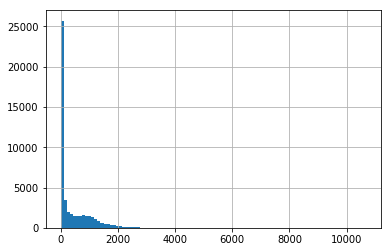

In [171]:
dry_eye['ACTUAL'].hist(bins=100);

### Видно из гистограммы, что продажи не распределены по нормальному закону 

## Диаграмма количества продаж в каждый месяц по годам

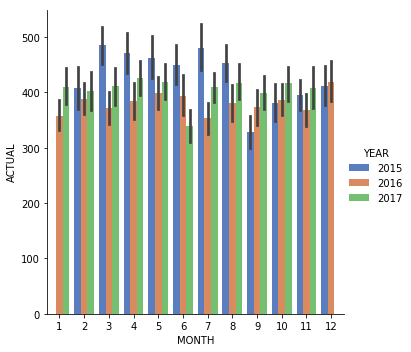

In [172]:
sns.catplot(x='MONTH', y='ACTUAL', hue='YEAR', data=dry_eye, kind='bar', palette='muted');

### Из графика продаж в принципе видно, что у данной категории нет никаких сезонных компонент

## Рассмотрим подробнее и попытаемся спрогнозировать продажи самого популярного продукта данной категории

In [173]:
dry_eye['PLN_LABEL'].value_counts()

BLINK GEL TEAR LUB EYE DROPS.34OZ    942
BLINK TEARS LUBRICATING DRPS .5OZ    935
BLINK TEARS LUBRICATING DROPS 1OZ    898
WALG ARTIFICIAL TEAR LBRCNT .5OZ     876
B&L SOOTHE LUB EYE DRPS .02OZ 28S    849
VISINE TEARS FOR DRY EYES    .5OZ    838
VISINE TEARS L/LST RLF DRYEYE.5OZ    826
SOOTHE HYDRATION DRY EYE DROP.5OZ    823
WALG LUB E DRP SNGL USE .01OZ 30S    819
SYSTANE ULT HIGH PERFORMANC .33OZ    797
WALG SODIUM CHLR OPTH ONT 5%.13OZ    785
SYSTANE LUB EYE DRP          .5OZ    782
B&L SOOTHE XP                15ML    779
SYSTANE BLNC LBRCNT EYE DROP.33OZ    776
SYSTANE PM LUBE EYE OINTMENT.12OZ    763
SYSTANE ULTRA            .33OZ 2S    753
WALG LUB E DRP SNGL USE .01OZ 70S    751
SYSTANE BALANCE EYE DROP .33OZ 2S    750
SIMILASAN E/DROP D/EYE 30014.33OZ    747
SIMILASAN CMPLT E RLF DRPS .33OZ     741
WALGREENS MURO 128 DROPS    .500Z    736
WALG ULT LUB EYEDRP VIAL .01OZ25S    726
SYSTANE LUB EYE DRP          30ML    721
SYSTANE ULTRA POCKET PACK.14OZ 2S    719
SYSTANE GEL DROP

In [174]:
first_item = dry_eye[dry_eye['PLN_LABEL']=='BLINK GEL TEAR LUB EYE DROPS.34OZ']

## Можем удалить колонки 'PLN' и 'PLN_LABEL', ведь мы уже определились с конкретным товаром 

In [175]:
first_item.drop(['PLN_LABEL', 'PLN'], axis=1, inplace=True)

In [176]:
first_item['WEEK'].value_counts()

2017-07-09    14
2017-05-28     8
2016-09-11     8
2016-10-09     8
2017-05-14     8
2017-03-12     8
2016-07-24     8
2016-11-06     8
2015-12-06     8
2016-04-17     8
2015-09-27     8
2017-02-12     8
2016-06-26     8
2015-11-08     8
2015-10-25     8
2016-06-12     8
2017-01-29     8
2017-06-04     8
2015-11-22     8
2016-07-10     8
2017-02-26     8
2017-04-30     8
2016-01-24     8
2017-03-26     8
2015-11-01     8
2016-11-13     8
2015-09-06     8
2016-04-24     8
2017-07-30     8
2015-10-04     8
              ..
2015-07-26     4
2015-08-23     4
2016-05-08     4
2015-03-01     4
2015-03-29     4
2015-04-26     4
2017-11-05     4
2015-05-24     4
2015-06-21     4
2016-02-07     4
2015-04-05     4
2017-08-20     4
2016-03-27     4
2017-01-01     4
2015-02-15     4
2016-05-22     4
2017-01-08     4
2015-03-15     4
2015-04-12     4
2015-05-10     4
2017-11-19     4
2015-06-07     4
2015-07-05     4
2016-02-21     4
2015-08-02     4
2016-03-20     4
2015-08-30     4
2015-02-08    

### Как видно выше недели повторяютя, сделаем так, чтобы на каждую конкретную неделю была только одна запись, для этого сложим все значения продаж для каждых повторяющихся недель. Также если хотя бы в одной из повторяющихся недель товар был на акции, то считаем, что и в "суммированной" недели он тоже будет на акции

In [177]:
weeks = np.unique(first_item['WEEK'].values)
sums = []
promos = []
indexes = first_item.index

In [178]:
for w in weeks:
    s = 0
    promo = 0
    for i in indexes:
        if first_item.at[i, 'WEEK']==w:
            s=s+first_item.at[i, 'ACTUAL']
            if first_item.at[i, 'PROMO']==1:
                promo = 1
    sums.append(s)
    promos.append(promo)

In [179]:
first_item1 = pd.DataFrame({'WEEK': weeks, 'ACTUAL': sums, 'PROMO': promos})

# Загрузим сразу данные на будующий год, для которого необходимо сделать прогноз 

In [180]:
future = pd.read_csv('future.csv', sep='|', error_bad_lines=False)

In [181]:
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199527 entries, 0 to 7199526
Data columns (total 4 columns):
1171126        int64
40000980460    int64
B              object
N              object
dtypes: int64(2), object(2)
memory usage: 219.7+ MB


In [182]:
future.head()

,1171126,40000980460,B,N
0,1171126,40000980460,NoSegment-C,N
1,1171126,40000980460,C4,N
2,1171126,40000223091,NoSegment-C,N
3,1171126,40000223091,C4,N
4,1171126,40000755059,A,N


## Переименуем столбцы

In [183]:
future.rename(index=str, columns={'1171126':'WEEK', '40000980460':'PLN', 'B':'SEG', 'N':'PROMO'}, inplace=True)

## Приведем данные в необходимые нам типы 

In [184]:
future['WEEK'] = future['WEEK'].apply(lambda x: str(x))

In [185]:
future['PLN'] = future['PLN'].apply(lambda x: str(x))

In [186]:
future['SEG'] = future['SEG'].apply(lambda x: str(x))

In [187]:
future['PROMO'] = future['PROMO'].apply(lambda x: str(x))

## Переведем WEEK в datetime 

In [188]:
future['WEEK'] = future['WEEK'].apply(lambda x: date_divide(x))

In [189]:
future['WEEK'] = pd.to_datetime(future['WEEK'])

## Заменим данные SEG на числовые 

In [190]:
future['SEG'] = future['SEG'].replace(seg_dic)

## Сделаем замену и для PROMO 

In [191]:
future['PROMO'] = future['PROMO'].replace(promo_dic)

In [192]:
future.head()

,WEEK,PLN,SEG,PROMO
0,2017-11-26,40000980460,8,0
1,2017-11-26,40000980460,7,0
2,2017-11-26,40000223091,8,0
3,2017-11-26,40000223091,7,0
4,2017-11-26,40000755059,0,0


## Возьмем отдуда необходимый нам продукт 

In [193]:
fut_first_prod = future[future['PLN']=='40000529197']

In [194]:
fut_first_prod.drop(['SEG', 'PLN'], axis=1, inplace=True)

In [195]:
fut_first_prod.head()

,WEEK,PROMO
91117,2017-11-26,0
91118,2017-11-26,0
91119,2017-11-26,0
91120,2017-11-26,0
144951,2017-12-03,1


### Как и в основном нашем наборе недели повторяются

In [196]:
fut_first_prod['PROMO'].value_counts()

0    173
1    163
Name: PROMO, dtype: int64

In [197]:
weeks = np.unique(fut_first_prod['WEEK'].values)
promos = []
indexes = fut_first_prod.index

In [198]:
for w in weeks:
    promo = 0
    for i in indexes:
        if fut_first_prod.at[i, 'WEEK']==w:
            if fut_first_prod.at[i, 'PROMO']==1:
                promo = 1
    promos.append(promo)

In [199]:
fut_first_prod1 = pd.DataFrame({'WEEK': weeks, 'PROMO': promos})

In [200]:
fut_first_prod1.head()

,WEEK,PROMO
0,2017-11-26,0
1,2017-12-03,1
2,2017-12-10,1
3,2017-12-17,1
4,2017-12-24,1


## Анализ временных рядов 

### Перед тем, как строить какие-либо графики и проводить анализ, необходимо нормализировать наши данные, чтобы удобнее на одном графике было увидеть, например, зависимость промо-акций и продаж 

In [201]:
df1 = first_item1.copy()

### Устанавливаем индексацию по неделям 

In [202]:
df1.set_index('WEEK', inplace=True)

### Проводим нормализацию 

In [203]:
scaler = MinMaxScaler()

In [204]:
scaler.fit(df1)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [205]:
df1_values = scaler.transform(df1)

In [206]:
df1 = pd.DataFrame({'WEEK': first_item1['WEEK'].values, 'ACTUAL': df1_values[:,0], 'PROMO': df1_values[:,1]})

In [207]:
df1.set_index('WEEK', inplace=True)

### Построим график продаж  

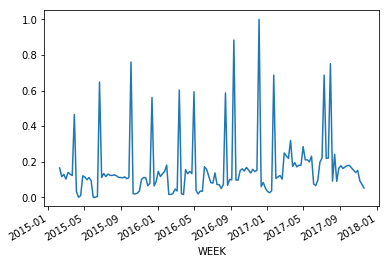

In [208]:
df1['ACTUAL'].plot();

### Как видно из графика, есть большое число каких-то колебаний (возможно связанных с промо-акциями) 

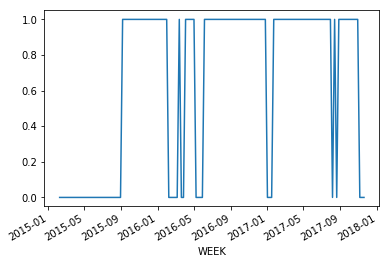

In [209]:
df1['PROMO'].plot();

### Чтобы сгладить краткосрочные колебания и выявить тенденции построим скользящую среднюю

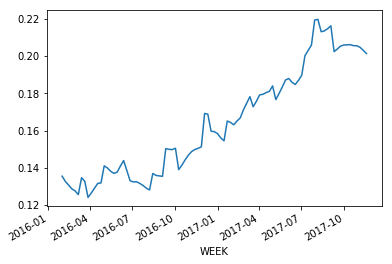

In [210]:
df1['ACTUAL'].rolling(52).mean().plot();

### Как видно из графика, имеется тенденция к росту продаж данного продукта 

### Построим разности первого порядка для промо и продаж 

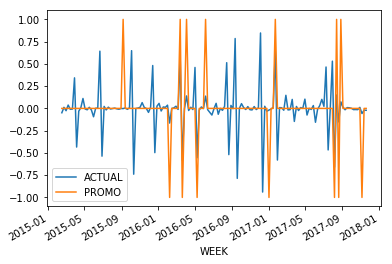

In [211]:
df1.diff().plot();

### Как видно из графика иногда резкие скачки в продажах сопровождаются наличием промо-акций, однако это не всегда так. Иногда присутствуют скачки в продажах, но акций в это время не было, возможно это вызвано какими-либо другими событиями и у нас не достаточно информации, чтобы это узнать 

### Теперь построим график автокорреляции 

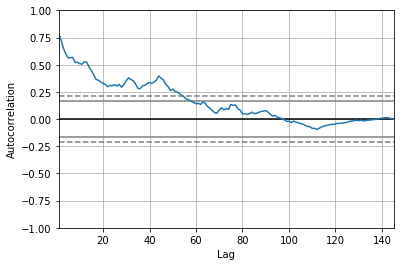

In [212]:
autocorrelation_plot(df1);

### Из графика видно, что существует положительная корреляция с первыми ~90 лагами, для параметра AR можно взять число 53 

## Для составления прогноза воспользуемся популярной моделью ARIMA

### Ограничимся только двумя признаками: WEEK и ACTUAL 

In [213]:
arima_df = df1[['ACTUAL']].copy()

###  Сперва разделим наши данные на тестовую и обучающую выборки и сделаем предсказание на 2017 год

In [214]:
arima_train = arima_df[:'2017-01-01']
arima_test = arima_df['2017-01-01':]

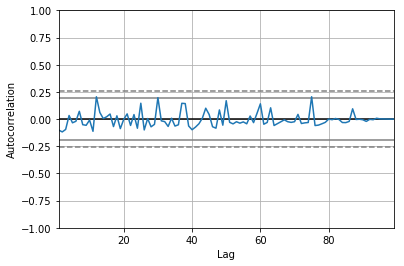

In [215]:
autocorrelation_plot(arima_train);

### Обучим нашу модель 

In [216]:
arima_model = ARIMA(arima_train, order=(0,1,0))
arima_model_fit = arima_model.fit(disp=0)

### Параметры нашей модели 

In [217]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.ACTUAL   No. Observations:                   98
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -10.671
Method:                           css   S.D. of innovations              0.270
Date:                Mon, 28 Jan 2019   AIC                             25.342
Time:                        11:58:02   BIC                             30.512
Sample:                             1   HQIC                            27.433
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.027     -0.049      0.961      -0.055       0.052
==============================================================================
"""

### Выведем график остаточных ошибок 

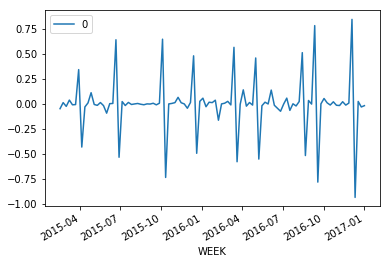

In [218]:
residuals = pd.DataFrame(arima_model_fit.resid)
residuals.plot();

### График плотности значений остаточных ошибок, предполагая, что ошибки являются гауссовыми

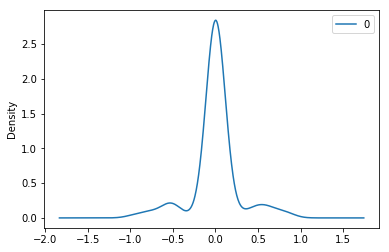

In [219]:
residuals.plot(kind='kde');

### Теперь сделаем прогноз 

In [288]:
train = arima_train.values
test = arima_test.values
new_train = [x for x in train]
prediction = []
for i in range(len(test)):
    arima_model = ARIMA(new_train, order=(0,1,0))
    arima_model_fit = arima_model.fit(disp=0)
    pred = arima_model_fit.forecast()
    prediction.append(pred[0])
    new_train.append(test[i])
    print('предсказанное=%f, ожидаемое=%f' % (pred[0], test[i]))

предсказанное=0.032854, ожидаемое=0.034194
предсказанное=0.032868, ожидаемое=0.026329
предсказанное=0.024938, ожидаемое=0.036758
предсказанное=0.035484, ожидаемое=0.686613
предсказанное=0.691722, ожидаемое=0.106514
предсказанное=0.105941, ожидаемое=0.115575
предсказанное=0.115095, ожидаемое=0.122927
предсказанное=0.122522, ожидаемое=0.102582
предсказанное=0.101988, ожидаемое=0.249786
предсказанное=0.250574, ожидаемое=0.232860
предсказанное=0.233484, ожидаемое=0.219012
предсказанное=0.219503, ожидаемое=0.320055
предсказанное=0.321460, ожидаемое=0.173705
предсказанное=0.173779, ожидаемое=0.195589
предсказанное=0.195858, ожидаемое=0.171653
предсказанное=0.171708, ожидаемое=0.181057
предсказанное=0.181193, ожидаемое=0.181228
предсказанное=0.181364, ожидаемое=0.285348
предсказанное=0.286381, ожидаемое=0.210976
предсказанное=0.211365, ожидаемое=0.211489
предсказанное=0.211879, ожидаемое=0.199863
предсказанное=0.200152, ожидаемое=0.231835
предсказанное=0.232387, ожидаемое=0.076081
предсказанн

### Среднеквадратическая ошибка 

In [221]:
mean_squared_error(test, prediction)

0.044552621543539825

### Графики ожидаемого и предсказанного 

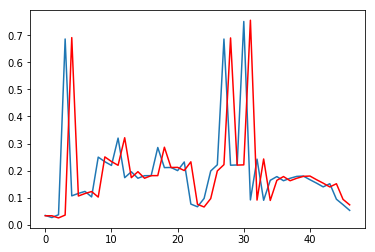

In [222]:
plt.plot(test);
plt.plot(prediction, color='red');

### Предсказание оказалось достаточно хорошим 

### Проделаем теперь тоже самое, но для прогноза на новый год (на 52 недели)

In [333]:
arima_data2 = first_item1.copy()

In [334]:
arima_data2.set_index('WEEK', inplace=True)

In [335]:
arima_data2.drop('PROMO', axis=1, inplace=True)

In [336]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [337]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [338]:
new_arima = [x for x in arima_data2.values]

In [345]:
differenced = difference(new_arima, 52)

### График ниже находится полностью в границах доверительных интервалов, следовательно параметр AR=0 

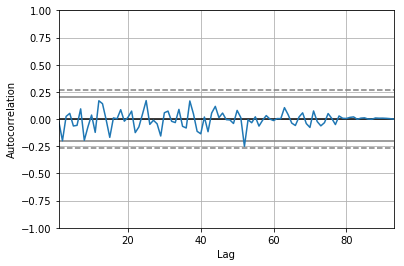

In [349]:
autocorrelation_plot(differenced);

In [354]:
arima_model = ARIMA(differenced, order=(0,1,0))
arima_model_fit = arima_model.fit(disp=0)

In [369]:
start_index = len(differenced)
end_index = start_index + 52
forecast = arima_model_fit.forecast(steps=52)[0]
history = [x for x in new_arima]
prediction = []
for yhat in forecast:
    inverted = inverse_difference(history, yhat, 52)
    prediction.append(inverted)
    history.append(inverted)

### Выведем предсказания 

In [370]:
prediction

[array([1379.56521739]),
 array([6340.13043478]),
 array([847.69565217]),
 array([991.26086957]),
 array([809.82608696]),
 array([705.39130435]),
 array([662.95652174]),
 array([727.52173913]),
 array([4532.08695652]),
 array([1142.65217391]),
 array([1199.2173913]),
 array([1245.7826087]),
 array([1130.34782609]),
 array([1994.91304348]),
 array([1899.47826087]),
 array([1822.04347826]),
 array([2416.60869565]),
 array([1564.17391304]),
 array([1695.73913043]),
 array([1559.30434783]),
 array([1617.86956522]),
 array([1622.43478261]),
 array([2235.]),
 array([1803.56521739]),
 array([1810.13043478]),
 array([1745.69565217]),
 array([1936.26086957]),
 array([1028.82608696]),
 array([974.39130435]),
 array([1157.95652174]),
 array([1755.52173913]),
 array([1893.08695652]),
 array([4616.65217391]),
 array([1891.2173913]),
 array([1899.7826087]),
 array([5007.34782609]),
 array([1150.91304348]),
 array([2036.47826087]),
 array([1150.04347826]),
 array([1585.60869565]),
 array([1670.173913

### График предсказаний 

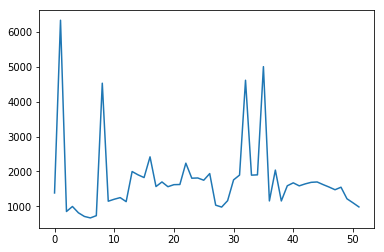

In [371]:
plt.plot(prediction);

## Прогноз при помощи Simple Exponential Smoothing

###  Метод простого экспоненциального сглаживания (SES) моделирует следующий временной шаг как экспоненциально взвешенную линейную функцию наблюдений на предыдущих временных шагах.

In [226]:
ses_train = df1[['ACTUAL']].copy()[:'2017-01-01']
ses_test = df1[['ACTUAL']].copy()['2017-01-01':]

In [227]:
train = ses_train.values
test = ses_test.values
new_train = [x for x in train]
prediction = []
for i in range(len(test)):
    ses_model = SimpleExpSmoothing(new_train)
    ses_model_fit = ses_model.fit()
    pred = ses_model_fit.forecast(12)
    prediction.append(pred[0])
    new_train.append(test[i])
    print('предсказанное=%f, ожидаемое=%f' % (pred[0], test[i]))

предсказанное=0.146980, ожидаемое=0.034194
предсказанное=0.145852, ожидаемое=0.026329
предсказанное=0.144669, ожидаемое=0.036758
предсказанное=0.143611, ожидаемое=0.686613
предсказанное=0.148883, ожидаемое=0.106514
предсказанное=0.148475, ожидаемое=0.115575
предсказанное=0.148162, ожидаемое=0.122927
предсказанное=0.147924, ожидаемое=0.102582
предсказанное=0.147500, ожидаемое=0.249786
предсказанное=0.148447, ожидаемое=0.232860
предсказанное=0.149222, ожидаемое=0.219012
предсказанное=0.149856, ожидаемое=0.320055
предсказанное=0.151390, ожидаемое=0.173705
предсказанное=0.151589, ожидаемое=0.195589
предсказанное=0.151978, ожидаемое=0.171653
предсказанное=0.152151, ожидаемое=0.181057
предсказанное=0.152402, ожидаемое=0.181228
предсказанное=0.152651, ожидаемое=0.285348
предсказанное=0.153785, ожидаемое=0.210976
предсказанное=0.154269, ожидаемое=0.211489
предсказанное=0.154750, ожидаемое=0.199863
предсказанное=0.155126, ожидаемое=0.231835
предсказанное=0.155760, ожидаемое=0.076081
предсказанн

### Среднеквадратическая ошибка 

In [228]:
mean_squared_error(test, prediction)

0.024141909764570497

### Графики ожидаемого и предсказанного 

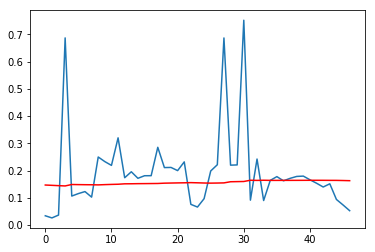

In [229]:
plt.plot(test);
plt.plot(prediction, color='red');

### Сделаем теперь предсказание на новый год 

In [230]:
new_ses = [x for x in df1[['ACTUAL']].copy().values]
prediction = []
for i in range(52):
    ses_model = SimpleExpSmoothing(new_ses)
    ses_model_fit = ses_model.fit()
    pred = ses_model_fit.predict(len(new_ses), len(new_ses))
    prediction.append(pred)
    new_arima.append(pred)

### Выведем предсказания 

In [231]:
prediction

[array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.1630317]),
 array([0.163

### График предсказаний 

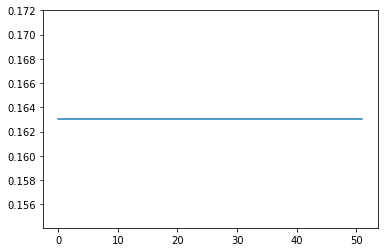

In [232]:
plt.plot(prediction);

### Видно, что модель делает прогноз плохо 

## Посмотрим теперь работу линейной регрессии на этих данных 

### В очередной раз проверим работу на тестовой выборке 

In [233]:
X = df1[['PROMO']].copy()

In [234]:
y = df1[['ACTUAL']].copy()

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Обучаем модель 

In [236]:
reg = LinearRegression().fit(X_train, y_train)

### Строим прогноз 

In [237]:
prediction = reg.predict(X_test)

### Среднеквадратическая ошибка 

In [238]:
mean_squared_error(np.asarray(y_test), prediction)

0.04534889320792337

### Выводим графики ожидаемого и предсказанного 

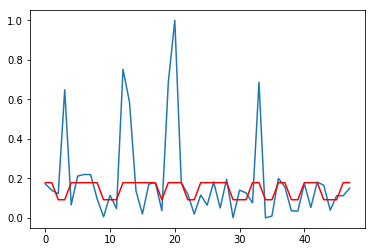

In [239]:
plt.plot(np.asarray(y_test));
plt.plot(prediction, color='red');

### Видно из графика, что модель достаточно хорошо предсказывает увеличение продаж во время акций, однако не может точно предсказать на сколько они вырастут

### Сделаем прогноз на следующий год 

In [240]:
fut_first_prod1.set_index('WEEK', inplace=True)

In [241]:
reg = LinearRegression().fit(X, y)

In [242]:
prediction = reg.predict(fut_first_prod1)

In [243]:
prediction

array([[0.09456003],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.09456003],
       [0.09456003],
       [0.09456003],
       [0.09456003],
       [0.09456003],
       [0.19798078],
       [0.09456003],
       [0.09456003],
       [0.19798078],
       [0.19798078],
       [0.19798078],
       [0.197

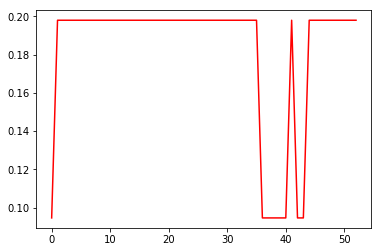

In [244]:
plt.plot(prediction, color='red');

In [245]:
data.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
0,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,2,Consumables,B,N
1,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,36,Consumables,C4,N
2,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1198,Health/Wellness,A,Y
3,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,9,Health/Wellness,A,N
4,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1479,Health/Wellness,C1,Y


In [246]:
consum = data[data['BU']=='Consumables']

In [247]:
for i in range(len(consum)):
    if 'EASTER' in consum.iloc[i]['PRODUCT_CATEGORY_LABEL']:
        print(consum.iloc[i]['PRODUCT_CATEGORY_LABEL'])
        break

EASTER


In [248]:
easter = consum[consum['PRODUCT_CATEGORY_LABEL']=='EASTER']

In [249]:
easter.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
105112,1160529,40000925255,CADBURY DAIRY MILK FRUIT&NUT 5.4Z,050-004,EASTER,50,CANDY BAG,3289,Consumables,C4,Y
105113,1160529,40000925255,CADBURY DAIRY MILK FRUIT&NUT 5.4Z,050-004,EASTER,50,CANDY BAG,873,Consumables,C4,N
105114,1160529,40000925255,CADBURY DAIRY MILK FRUIT&NUT 5.4Z,050-004,EASTER,50,CANDY BAG,0,Consumables,B,Y
105115,1160529,40000925255,CADBURY DAIRY MILK FRUIT&NUT 5.4Z,050-004,EASTER,50,CANDY BAG,51,Consumables,NoSegment-C,N
113849,1160529,40000925592,NICE JELLY BEANS 7OZ,050-004,EASTER,50,CANDY BAG,11153,Consumables,A,N


In [250]:
easter.drop(['PRODUCT_CATEGORY', 'PRODUCT_CATEGORY_LABEL', 'OPSTUDY', 'OPSTUDY_LABEL', 'BU'], axis=1, inplace=True)

In [251]:
easter['WEEK'] = easter['WEEK'].apply(lambda x: str(x))

In [252]:
easter['PLN'] = easter['PLN'].apply(lambda x: str(x))

In [253]:
easter['PLN_LABEL'] = easter['PLN_LABEL'].apply(lambda x: str(x))

In [254]:
easter['ACTUAL'] = easter['ACTUAL'].apply(lambda x: float(x))

In [255]:
easter['SEG'] = easter['SEG'].apply(lambda x: str(x))

In [256]:
easter['PROMO'] = easter['PROMO'].apply(lambda x: str(x))

## Преобразуем признак WEEK в datetime и создадим три новых колонки: YEAR, MONTH, DAY для того, чтобы, например, посмотреть как менялись продажи товара каждый месяц в разные года

### Колонка WEEK имеет неподходящий вид для перевода в тип datetime, поэтому напишем функцию, чтобы немного преобразовать данные в этой колонке

In [257]:
easter['WEEK'] = easter['WEEK'].apply(lambda x: date_divide(x))

### Переводим данные в дату 

In [258]:
easter['WEEK'] = pd.to_datetime(easter['WEEK'])

### Создаем новые три колонки с годом, месяцем и днем (неделей) 

In [259]:
easter['YEAR'] = [d.year for d in easter['WEEK']]
easter['MONTH'] = [d.month for d in easter['WEEK']]
easter['DAY'] = [d.day for d in easter['WEEK']]

## Заменим значения признака SEG на числовые 

### Создаем словарь, дге каждому строковому значению признака соответствует число 

In [260]:
easter['SEG'] = easter['SEG'].replace(seg_dic)

## Если в датасете имеются отрицательные значения продаж, то заменим их на нулевые

In [261]:
easter['ACTUAL'] = easter['ACTUAL'].apply(lambda x: replace_negative(x))

## Заменим значения PROMO 'Y', 'N' на 1, 0

In [262]:
easter['PROMO'] = easter['PROMO'].replace(promo_dic)

## Взглянем на получившейся набор после преобразований 

In [263]:
easter.head()

,WEEK,PLN,PLN_LABEL,ACTUAL,SEG,PROMO,YEAR,MONTH,DAY
105112,2016-05-29,40000925255,CADBURY DAIRY MILK FRUIT&NUT 5.4Z,3289.0,7,1,2016,5,29
105113,2016-05-29,40000925255,CADBURY DAIRY MILK FRUIT&NUT 5.4Z,873.0,7,0,2016,5,29
105114,2016-05-29,40000925255,CADBURY DAIRY MILK FRUIT&NUT 5.4Z,0.0,2,1,2016,5,29
105115,2016-05-29,40000925255,CADBURY DAIRY MILK FRUIT&NUT 5.4Z,51.0,8,0,2016,5,29
113849,2016-05-29,40000925592,NICE JELLY BEANS 7OZ,11153.0,0,0,2016,5,29


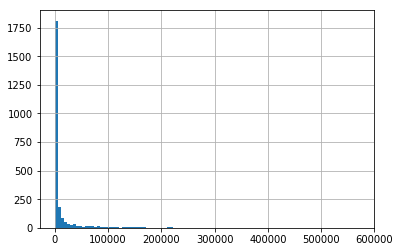

In [264]:
easter['ACTUAL'].hist(bins=100);

## Выведем диаграмму продаж помесячно в разные года 

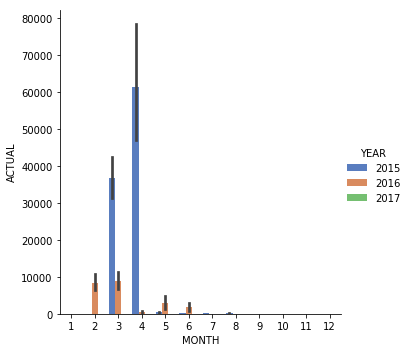

In [265]:
sns.catplot(x='MONTH', y='ACTUAL', hue='YEAR', data=easter, kind='bar', palette='muted');

### Сразу видно, что товары сезонные, так как продаются только весной перед пасхой 

## Исходя из диаграммы продаж, видно, что в 2015 году товары продавались гораздо активнее по сравнению с другими годами. Возможно это как-то связано с акциями 

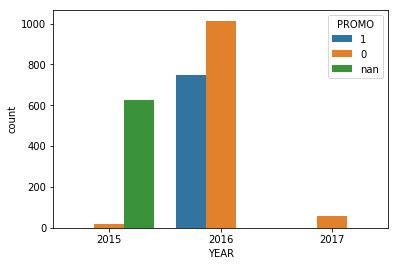

In [266]:
sns.countplot(x='YEAR', hue='PROMO', data=easter);

### Однако диаграмма количества акций говорит нам об обратном. Оказывается наибольшее число акций было в 2016 году 

In [267]:
easter['PLN_LABEL'].value_counts()

SCATCH BALL & DISC CTCH GAME         180
(E)MARS M&MS MALT ESTR 9.9OZ          58
(E)PLUSH ANIMAL PPR AST               45
(E)R/S COCONUT/ALMND EGG      1OZ     40
(E)R/S EXT CRNCHY PNT BTR EGG 1OZ     36
(E)R/S MILK CHOC TRUFFLE EGG  1OZ     36
(E)R/S MILK CHOC STRWBRY CR EGG1Z     36
(E)R/S MILK CHOC VANILA CRM EGG1Z     36
(E)R/S CHOC MARSHMALLOW EGG   1OZ     36
(E)R/S MC M/MALLOW EGG 364    1OZ     36
(E)R/S S/F MARSHMALLOW EGG    1OZ     36
(E)R/S DARK CHOC M/MLW EGG    1OZ     36
(E)R/S MAPLE CREAM EGG 375    1OZ     36
(E)RUSSELL STOVER D/CH RSP EGG1OZ     36
(E)R/S COCONUT CR EGG 372     1OZ     36
(E)R/S MILK CHOC CARAMEL EGG  1OZ     36
(E)R/S COCONUT NEST CHOCOLATE 1OZ     36
(E)WHITMAN S M/C FLTB RABBIT  3OZ     35
(E)R/S BUNNY MLK CHOC 843     3OZ     35
(E)MARS DOVE DRK/CHOC EGG  8.87OZ     34
(E)R/S COOKIES N CREAM RABBIT 3OZ     31
(E)HELLO KITTY GREETER    PPR AST     31
(E)R/S MILK CHOC PB RABBIT    3OZ     31
(E)BUTTERFINGER PB CUP MINI 10.5Z     30
(E)MARS DOVE M/C

In [268]:
easter[easter['YEAR']==2015]['PLN_LABEL'].value_counts()

SCATCH BALL & DISC CTCH GAME         44
R/S M/M BUNNY 341             2OZ     6
(E)R/S PEANUT BUTTER EGG      1OZ     6
(E)RS CARROT CAKE EGG         1OZ     6
(E)R/S MILK CHOC STRWBRY CR EGG1Z     6
(E)PLUSH FRIENDS W/BOW 7.5 PPR A      6
(E)R/S WHT PSTL FLAT RABBIT   7OZ     6
(E)R/S CHOC MARSHMALLOW EGG   1OZ     6
(E)LINDT CHOC CARROTS    1.8OZ 4S     6
(E)R/S DARK CHOC M/MLW EGG    1OZ     6
(E)HOPPY BUNNY 14.5      PPR AST      6
(E)PEEP SOFT BUNNY 17    PPR AST      6
(E)LAYING ANIMAL    23.5 PPR AST      6
(E)JUNGLE ANIMALS         PPR AST     6
(E)R/S BUNNY HOLW CHOC      1.5OZ     6
(E)R/S J/BEANS MINI BAG 83271.5OZ     6
R/S MRSHMLLOW BUNNY S/F 1.75OZ        6
(E)DOVE WHT CHOC EASTR BUNNY 4.5Z     6
(E)R/S CKS-N-CR FLB RBT 1.5Z DISP     6
(E)PLUSH PUPPY 7 PPR AST              6
(E)BASHFUL BUNNY    14.5 PPR AST      6
(E)R/S DC RED VELVET EGG 1OZ DISP     6
(E)R/S EGG MARSHMALLOW EGG    1OZ     6
(E)RUMPEES                PPR AST     6
(E)PLUSH LAMB/WOOLY BUNNY PPR AST     6


In [269]:
easter[easter['YEAR']==2016]['PLN_LABEL'].value_counts()

SCATCH BALL & DISC CTCH GAME         78
(E)MARS M&MS MALT ESTR 9.9OZ         58
(E)PLUSH ANIMAL PPR AST              39
(E)R/S COCONUT/ALMND EGG      1OZ    34
(E)MARS DOVE DRK/CHOC EGG  8.87OZ    34
(E)R/S MILK CHOC STRWBRY CR EGG1Z    30
(E)R/S MILK CHOC VANILA CRM EGG1Z    30
(E)R/S DARK CHOC M/MLW EGG    1OZ    30
(E)MILK CHOC KEY LIME PIE EGG 1OZ    30
(E)R/S MILK CHOC CARAMEL EGG  1OZ    30
(E)R/S MC M/MALLOW EGG 364    1OZ    30
(E)R/S CHOC MARSHMALLOW EGG   1OZ    30
(E)CADBURY WHITE EGGS BAG 7OZ        30
(E)R/S COCONUT CR EGG 372     1OZ    30
(E)R/S EXT CRNCHY PNT BTR EGG 1OZ    30
(E)MARS DOVE M/C COCONT EGG7.94OZ    30
(E)R/S S/F MARSHMALLOW EGG    1OZ    30
(E)R/S MILK CHOC TRUFFLE EGG  1OZ    30
(E)BUTTERFINGER PB CUP MINI 10.5Z    30
(E)RUSSELL STOVER D/CH RSP EGG1OZ    30
(E)R/S COCONUT NEST CHOCOLATE 1OZ    30
(E)R/S MAPLE CREAM EGG 375    1OZ    30
(E)R/S BUNNY MLK CHOC 843     3OZ    29
(E)WHITMAN S M/C FLTB RABBIT  3OZ    29
(E)MARS M&MS CRISPY ESTR 9.9OZ       28


In [270]:
easter[easter['YEAR']==2017]['PLN_LABEL'].value_counts()

SCATCH BALL & DISC CTCH GAME    58
Name: PLN_LABEL, dtype: int64

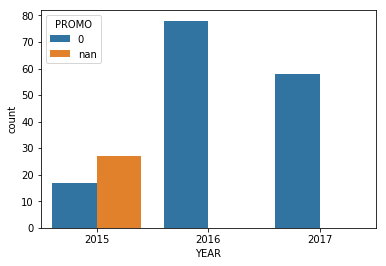

In [271]:
sns.countplot(x='YEAR', hue='PROMO', data=easter[easter['PLN_LABEL']=='SCATCH BALL & DISC CTCH GAME']);

In [272]:
easter[easter['MONTH']>=6]['PLN_LABEL'].value_counts()

SCATCH BALL & DISC CTCH GAME         89
CADBURY RYL DRK SLTD CRMLO 5.5Z8S     9
CADBURY DAIRY MILK FRUIT&NUT 5.4Z     8
NICE JELLY BEANS 7OZ                  8
CADBURY DAIRY MC ENGSH TOFFEE5.4Z     6
CADBURY RYL DRK CREAMY MNT 5.5Z8S     6
Name: PLN_LABEL, dtype: int64

In [273]:
ball = easter[easter['PLN_LABEL']=='SCATCH BALL & DISC CTCH GAME'].copy()

In [274]:
ball.drop(['PLN', 'PLN_LABEL', 'YEAR', 'MONTH', 'DAY'], axis=1, inplace=True)

In [275]:
weeks = np.unique(ball['WEEK'].values)
sums = []
promos = []
indexes = ball.index

In [276]:
for w in weeks:
    s = 0
    promo = 0
    for i in indexes:
        if ball.at[i, 'WEEK']==w:
            s=s+ball.at[i, 'ACTUAL']
            if ball.at[i, 'PROMO']==1:
                promo = 1
    sums.append(s)
    promos.append(promo)

In [277]:
ball1 = pd.DataFrame({'WEEK': weeks, 'ACTUAL': sums, 'PROMO': promos})

In [278]:
ball1.head()

,WEEK,ACTUAL,PROMO
0,2015-03-01,71.0,0
1,2015-03-08,148.0,0
2,2015-03-15,207.0,0
3,2015-03-22,165.0,0
4,2015-03-29,401.0,0


In [279]:
ball1.set_index('WEEK', inplace=True)

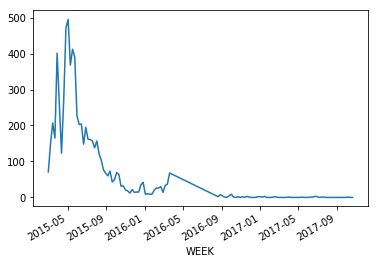

In [280]:
ball1['ACTUAL'].plot();

In [281]:
train = ball1.copy()[:'2017-01-01'].drop(['PROMO'], axis=1)
test = ball1.copy()['2017-01-01':].drop(['PROMO'], axis=1)

In [282]:
train1 = train.values
test1 = test.values
new_train = [x for x in train1]
prediction = []
for i in range(len(test)):
    es_model = SimpleExpSmoothing(new_train)
    es_model_fit = es_model.fit()
    pred = es_model_fit.predict(len(new_train), len(new_train))
    prediction.append(pred[0])
    new_train.append(test1[i])
    print('предсказанное=%f, ожидаемое=%f' % (pred[0], test1[i]))

предсказанное=1.909264, ожидаемое=2.000000
предсказанное=1.980612, ожидаемое=1.000000
предсказанное=1.209538, ожидаемое=3.000000
предсказанное=2.617385, ожидаемое=0.000000
предсказанное=0.559415, ожидаемое=0.000000
предсказанное=0.119554, ожидаемое=0.000000
предсказанное=0.025550, ожидаемое=1.000000
предсказанное=0.791735, ожидаемое=2.000000
предсказанное=1.741776, ожидаемое=0.000000
предсказанное=0.372277, ожидаемое=0.000000
предсказанное=0.079567, ожидаемое=0.000000
предсказанное=0.017005, ожидаемое=0.000000
предсказанное=0.003635, ожидаемое=0.000000
предсказанное=0.000777, ожидаемое=1.000000
предсказанное=0.786438, ожидаемое=0.000000
предсказанное=0.168091, ожидаемое=0.000000
предсказанное=0.035927, ожидаемое=0.000000
предсказанное=0.007679, ожидаемое=0.000000
предсказанное=0.001641, ожидаемое=0.000000
предсказанное=0.000351, ожидаемое=1.000000
предсказанное=0.786336, ожидаемое=0.000000
предсказанное=0.168075, ожидаемое=0.000000
предсказанное=0.035924, ожидаемое=0.000000
предсказанн

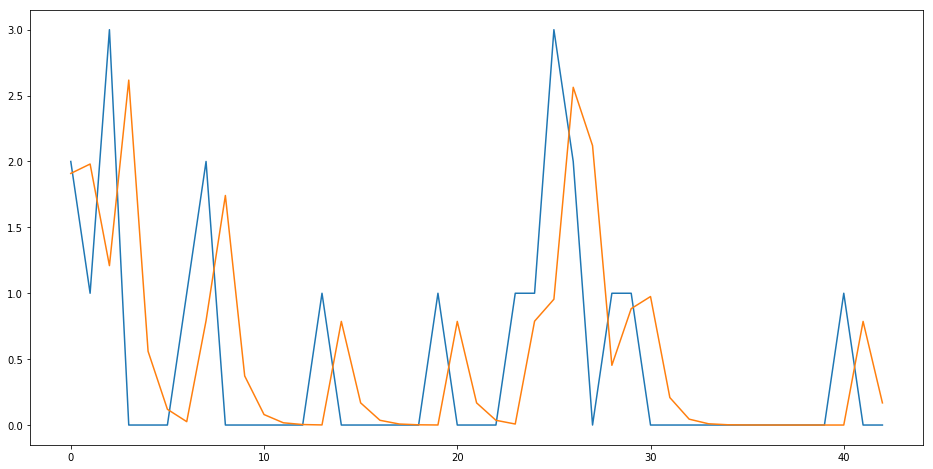

In [283]:
plt.figure(figsize=(16,8))
plt.plot(np.asarray(test['ACTUAL']))
plt.plot(prediction)
plt.show()

In [284]:
new_es = [x for x in ball1.copy().drop(['PROMO'], axis=1).values]
prediction = []
for i in range(52):
    es_model = ExponentialSmoothing(new_es)
    es_model_fit = es_model.fit()
    pred = es_model_fit.forecast()
    prediction.append(pred[0])
    new_es.append(pred[0])

In [285]:
prediction

[0.03592685718855348,
 0.03592674950967605,
 0.03592680199066482,
 0.03592679755173297,
 0.03592679784492075,
 0.035926797831054395,
 0.03592679777560568,
 0.03592679777954245,
 0.03592679778262691,
 0.0359267977823464,
 0.03592679778241438,
 0.03592679778241944,
 0.03592679778240891,
 0.0359267977824095,
 0.035926797782409724,
 0.03592679778240969,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.035926797782409696,
 0.0

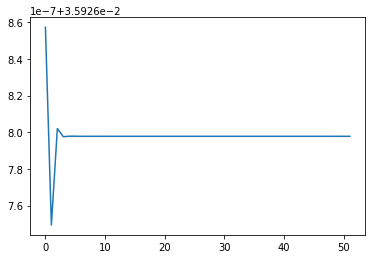

In [286]:
plt.plot(prediction);